<참고문헌>

- https://today-1.tistory.com/60

# Drive mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#----------------------------------------
#
# <변동사항>
#
# 현재 파일의 경로 입력
#
#----------------------------------------
%cd '/content/drive/MyDrive/Colab Notebooks/TAEMTAEM class/final'

/content/drive/MyDrive/Colab Notebooks/TAEMTAEM class/final


In [3]:
!ls

data_tr_city.csv  model.pth	      NLinear_train.ipynb
data_ts_city.csv  NLinear_test.ipynb


# Import

In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Data download

In [5]:
from google.colab import files

#----------------------------------------
#
# <변동사항>
#
# 사용하고자 하는 파일 업로드
#
#----------------------------------------
#files.upload()

In [6]:
!ls

data_tr_city.csv  model.pth	      NLinear_train.ipynb
data_ts_city.csv  NLinear_test.ipynb


# Data preprocessing

In [96]:
#----------------------------------------
#
# <변동사항>
#
# 업로드한 파일 이름 입력
#
#----------------------------------------
test_df_raw = pd.read_csv('data_ts_city.csv')

datetime               0
구미 혁신도시배수지 유출유량 적산차    0
dtype: int64


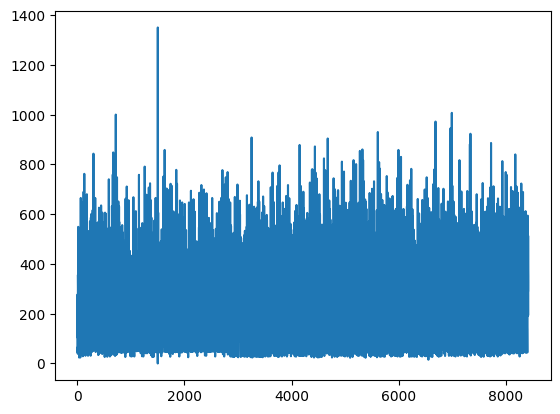

In [97]:
print(test_df_raw.isna().sum())
plt.plot(test_df_raw.iloc[:,1])

In [98]:
# test_df = test_df_raw.copy()
# test_df[test_df.iloc[:,1]>2000] = None
# test_df[test_df.iloc[:,1]<0] = None
# test_df = test_df.interpolate()

test_df_x = test_df_raw.copy()
test_df_x = test_df_x.fillna(method='ffill')

test_df_y = test_df_raw.copy()
test_df_y = test_df_y.fillna(0)

datetime               0
구미 혁신도시배수지 유출유량 적산차    0
dtype: int64
datetime               0
구미 혁신도시배수지 유출유량 적산차    0
dtype: int64


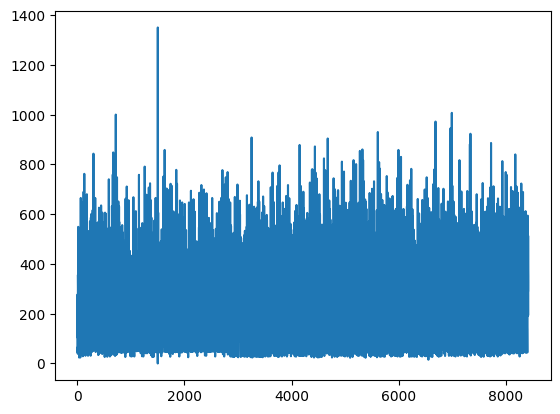

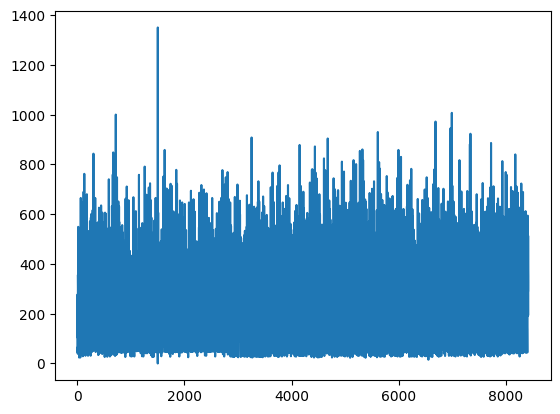

In [99]:
# print(test_df.isna().sum())
# plt.plot(test_df.iloc[:,1])

print(test_df_x.isna().sum())
plt.plot(test_df_x.iloc[:,1])

plt.figure()
print(test_df_y.isna().sum())
plt.plot(test_df_y.iloc[:,1])

In [100]:
# test_data = np.array(test_df.iloc[:,1].tolist()).reshape(-1,1)

test_data_x = np.array(test_df_x.iloc[:,1].tolist()).reshape(-1,1)

test_data_y = np.array(test_df_y.iloc[:,1].tolist()).reshape(-1,1)

In [101]:
def time_slide_df(data, window_size, forcast_size):
    X = []
    Y = []

    for i in range(len(data)-window_size-forcast_size):
        feature = data[i:i+window_size]
        target = data[i+window_size:i+window_size+forcast_size]
        X.append(feature)
        Y.append(target)

    return torch.tensor(X).float(), torch.tensor(Y).float()

In [102]:
#window_size = 144
#window_size = 360
window_size = 336
forcast_size= 24

# test_x, test_y = time_slide_df(test_data, window_size, forcast_size)

test_x, _ = time_slide_df(test_data_x, window_size, forcast_size)

_, test_y = time_slide_df(test_data_y, window_size, forcast_size)

# NLinear model

In [103]:
class LTSF_NLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, individual, feature_size):
        super(LTSF_NLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(torch.nn.Linear(self.window_size, self.forcast_size))
        else:
            self.Linear = torch.nn.Linear(self.window_size, self.forcast_size)

    def forward(self, x):
        seq_last = x[:,-1:,:].detach()
        x = x - seq_last
        if self.individual:
            output = torch.zeros([x.size(0), self.forcast_size, x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        x = x + seq_last
        return x

# Model load

In [104]:
!ls

data_tr_city.csv  model.pth	      NLinear_train.ipynb
data_ts_city.csv  NLinear_test.ipynb


In [105]:
model = torch.load('model.pth')

# Model test

In [106]:
predict = model(test_x)

In [107]:
criterion = torch.nn.L1Loss()
loss = criterion(predict, test_y)
loss

tensor(87.7894, grad_fn=<MeanBackward0>)

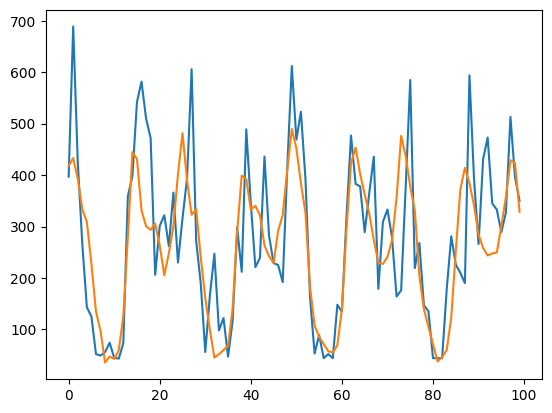

In [108]:
plt.plot(test_y.detach().numpy().squeeze(-1)[-100:,-1])
plt.plot(predict.detach().numpy().squeeze(-1)[-100:,-1])

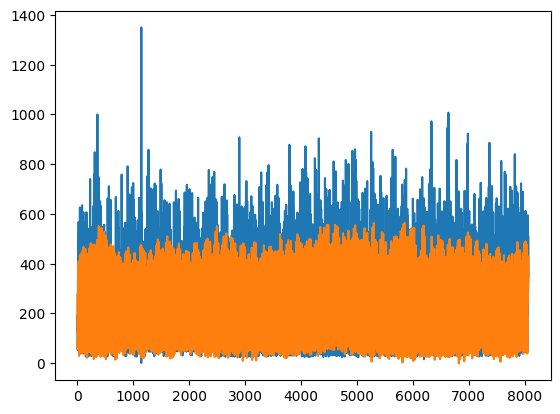

In [109]:
plt.plot(test_y.detach().numpy().squeeze(-1)[:,-1])
plt.plot(predict.detach().numpy().squeeze(-1)[:,-1])